# 1. Import libraries

In [11]:
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append("./src/semantic")

import colorsys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# our scripts
from src.semantic.perform_clustering import run_all_clustering, run_kimchi_cos
from src.semantic.utils.evaluate_clustering import (
    calculate_clustering_consistency, get_primary_category,
    map_clustering_category)

# 2. Calculate Semantic Distances for articles

## 2.1 Define file paths 

In [12]:
# Path to the category data file
category_file = './/data//wikispeedia//wikispeedia_paths-and-graph//categories.tsv'

# All paths to the embedding data files
MiniLM_file = './/data//semantic//output//embeddings_v2//all_MiniLM_L6_v2.pkl' 
mpnet_file = './/data//semantic//output//embeddings_v2//all_mpnet_base_v2.pkl' 
roberta_file = './/data//semantic//output//embeddings_v2//roberta.pkl' 

## 2.2 Perform Clustering on embeddings

In [13]:
# For embeddings generated from MiniLM
print('------Starting clustering for embeddings based on MiniLM_L6_v2...')
MiniLM_clustering = run_all_clustering(MiniLM_file, category_file)
print(f"Perform {list(MiniLM_clustering.keys())} successfully!")

# For embeddings generated from mpnet_base_v2
print('------Starting clustering for embeddings based on mpnet_base_v2...')
mpnet_clustering = run_all_clustering(mpnet_file, category_file)
print(f"Perform {list(mpnet_clustering.keys())} successfully!")

# Cluster embeddings generated from roberta
print('------Starting clustering for embeddings based on roberta...')
roberta_clustering = run_all_clustering(roberta_file, category_file)
print(f"Perform {list(roberta_clustering.keys())} successfully!")

------Starting clustering for embeddings based on MiniLM_L6_v2...
15 categories found in wikispeedia.


100%|██████████| 4/4 [00:06<00:00,  1.60s/it]


Perform ['K-Means', 'K-Medoids_Manhattan', 'K-Medoids_Cosine', 'Spectral_Clustering_NN'] successfully!
------Starting clustering for embeddings based on mpnet_base_v2...
15 categories found in wikispeedia.


100%|██████████| 4/4 [00:09<00:00,  2.49s/it]


Perform ['K-Means', 'K-Medoids_Manhattan', 'K-Medoids_Cosine', 'Spectral_Clustering_NN'] successfully!
------Starting clustering for embeddings based on roberta...
15 categories found in wikispeedia.


100%|██████████| 4/4 [00:16<00:00,  4.22s/it]

Perform ['K-Means', 'K-Medoids_Manhattan', 'K-Medoids_Cosine', 'Spectral_Clustering_NN'] successfully!


The data structure of the clustering results is as follows:

- **MiniLM_clustering**
  - **K-Means**: Embeddings (DataFrame)
  - **K-Medoids Manhattan**: Embeddings (DataFrame)
  - **K-Medoids Cosine**: Embeddings (DataFrame)
  - **Spectral Clustering NN**: Embeddings (DataFrame)
  - **Spectral Clustering RBF**: Embeddings (DataFrame)

In [14]:
# A sample of clustering results
MiniLM_clustering['K-Means'].head(5)

,concept,clustering
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,0
1,%C3%85land,3
2,%C3%89douard_Manet,4
3,%C3%89ire,0
4,%C3%93engus_I_of_the_Picts,0


## 2.3 Evaluate the clustering results

### 2.3.1 Clustering Consistency

In [15]:
# Extract clustering results from each DataFrame's 'clustering' column and store in a list
MiniLM_list = [df['clustering'].tolist() for df in MiniLM_clustering.values()]
mpnet_list = [df['clustering'].tolist() for df in mpnet_clustering.values()]
roberta_list = [df['clustering'].tolist() for df in roberta_clustering.values()]

# Calculate average clustering consistency for each embedding
MiniLM_ari, MiniLM_nmi = calculate_clustering_consistency(MiniLM_list)
mpnet_ari, mpnet_nmi = calculate_clustering_consistency(mpnet_list)
roberta_ari, MiniLM_nmi = calculate_clustering_consistency(roberta_list)

# Show the result 
clustering_consistency = pd.DataFrame({
    'Average ARI': [MiniLM_ari, mpnet_ari, roberta_ari],
    'Average NMI': [MiniLM_nmi, mpnet_nmi, MiniLM_nmi]
})
clustering_consistency.index = ['MiniLM', 'mpnet', 'roberta']

clustering_consistency

,Average ARI,Average NMI
MiniLM,0.197762,0.279214
mpnet,0.176664,0.348972
roberta,0.152799,0.279214


- **ARI** and **NMI** are two methods used to evaluate consistency across different clustering results.
- **Adjusted Rand Index (ARI):** ARI measures the similarity between two clustering results by considering pairs of points and evaluating how consistently they are grouped across different clusters. (Range: [-1, 1])
- **Normalized Mutual Information (NMI):** NMI evaluates the amount of shared information between two clustering results, assessing how well one clustering result predicts the other. (Range: [0, 1])
- **Embeddings generated by mpnet** shows the highest scores for both Average ARI (0.147835) and Average NMI (0.317228), indicating the best consistency and stability among the models.

### 2.3.2 Category-Cluster Mapping and Accuracy Evaluation

In [16]:
# Get primary categories for concepts and show the head
primary_category = get_primary_category(category_file)
primary_category.head(5)

,concept,primary_category
0,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,History
1,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,People
2,%C3%85land,Countries
3,%C3%85land,Geography
4,%C3%89douard_Manet,People


In [17]:
# Set dicts to save the mapping results
MiniLM_evaluation = {}
mpnet_evaluation = {}
roberta_evaluation = {}

# evaluation on MiniLM_L6_v2
print("------Clustering accuracy for MiniLM_L6_v2 embeddings:")
for key, value in MiniLM_clustering.items():
    cluster_category_mapping, accuracy = map_clustering_category(primary_category, value)
    MiniLM_evaluation['key'] = cluster_category_mapping
    print(f"{key}: {accuracy:.2f}")

# evaluation on mpnet_base_v2
print("------Clustering accuracy for mpnet_base_v2 embeddings:")
for key, value in mpnet_clustering.items():
    cluster_category_mapping, accuracy = map_clustering_category(primary_category, value)
    mpnet_evaluation['key'] = cluster_category_mapping
    print(f"{key}: {accuracy:.2f}")

# evaluation on mpnet_base_v2
print("------Clustering accuracy for roberta embeddings:")
for key, value in roberta_clustering.items():
    cluster_category_mapping, accuracy = map_clustering_category(primary_category, value)
    roberta_evaluation['key'] = cluster_category_mapping
    print(f"{key}: {accuracy:.2f}")

------Clustering accuracy for MiniLM_L6_v2 embeddings:
K-Means: 0.25
K-Medoids_Manhattan: 0.25
K-Medoids_Cosine: 0.26
Spectral_Clustering_NN: 0.33
------Clustering accuracy for mpnet_base_v2 embeddings:
K-Means: 0.34
K-Medoids_Manhattan: 0.26
K-Medoids_Cosine: 0.26
Spectral_Clustering_NN: 0.29
------Clustering accuracy for roberta embeddings:
K-Means: 0.30
K-Medoids_Manhattan: 0.20
K-Medoids_Cosine: 0.21
Spectral_Clustering_NN: 0.38


- Among all embedding models, mpnet shows the highest degree of alignment with the original primary categories.

# 3. Evaluation of different embedings by comparing a clustering to the primary categories 

## Method
We use kmedoids with the **cosine distance** to cluster the embeddings.
We set the number of clusters to be equal to the number of primary categories.

## Motivations
We use cosine distance because it normalises vectors and by doing so, we make sure that the size of the article doesn't act as a confounding factor.
We use kmedoids to extract meaning for each cluster by looking at the name and primary category of the center.

In [21]:
category_df = pd.read_csv(category_file, sep='\t', skiprows=12, header=None)
category_df.columns = ['concept','category']
category_df['primary_category'] = category_df['category'].apply(lambda x: x.split('.')[1])
category_dict = dict(zip(category_df['concept'], category_df['primary_category']))

models = ['all_MiniLM_L6_v2', 'all_mpnet_base_v2', 'roberta']

model_clustering_dfs = []
for model_name in models:
    model_file = f'.//data//semantic//output//embeddings_v2//{model_name}.pkl'
    model_cluster = run_kimchi_cos(model_file, category_file)
    model_cluster['center_category'] = model_cluster['center_name'].map(category_dict)
    model_cluster['members_categories'] = model_cluster['member_names'].apply(
        lambda members: [category_dict.get(member, 'Unknown') for member in members]
    )
    model_clustering_dfs.append(model_cluster)


for i, clustering_df in enumerate(model_clustering_dfs): 
    print(models[i])
    print(clustering_df[['center_name', 'center_category', 'cluster_size']])

15 categories found in wikispeedia.
15 categories found in wikispeedia.
15 categories found in wikispeedia.
all_MiniLM_L6_v2
                   center_name center_category  cluster_size
0                     Pliocene       Geography           422
1                  9th_century         History           377
2   History_of_the_Netherlands         History           177
3                       Prague       Geography           449
4                      Miocene       Geography           199
5                    Attalus_I          People           364
6            List_of_countries       Geography           269
7                 11th_century         History           263
8                  Global_city       Geography           308
9                    Radhanite         History           245
10                     Country       Geography           238
11           League_of_Nations     Citizenship           282
12              Modern_history         History           343
13                   

## Observations 
Most of the cluster centers are related to Science. This is not very surprinsing because, science is the biggest primary category : 

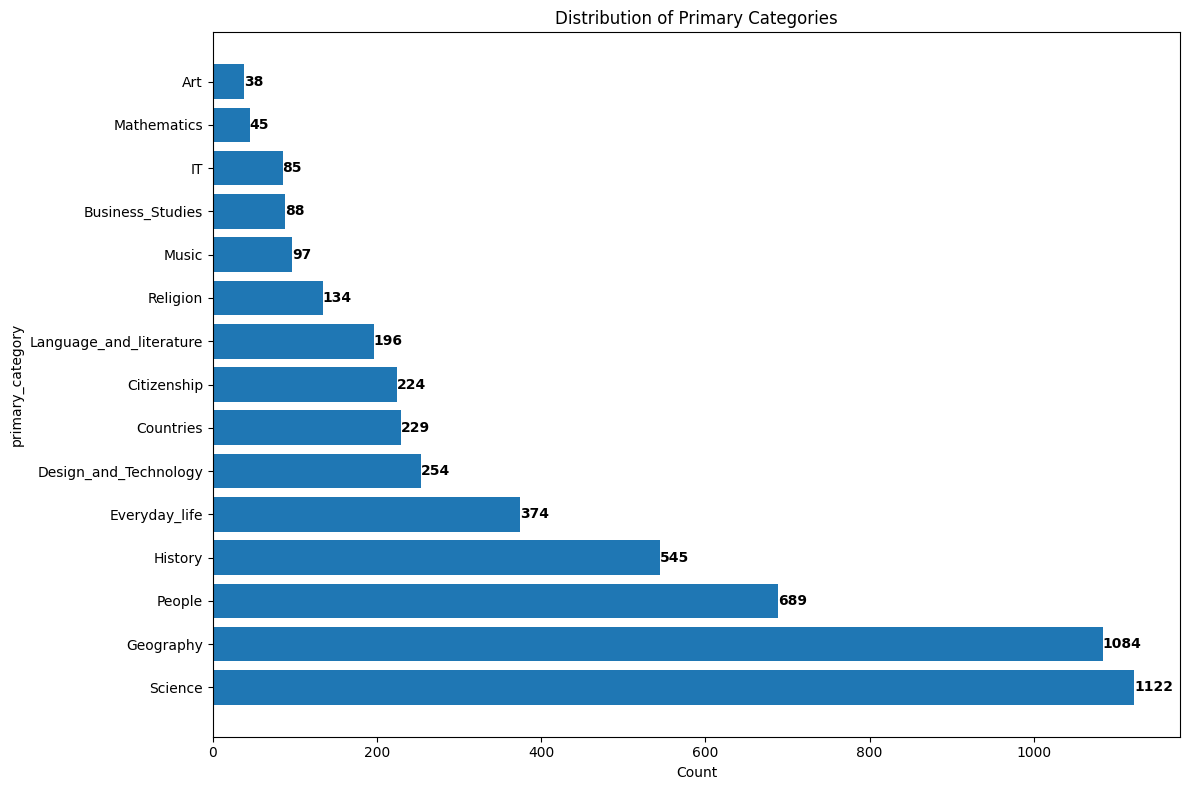

In [22]:
def plot_distribution(df, column, title=None, figsize=(12, 8), top_n=None, sort_by='value'):
    """
    Plot the distribution of values in a specified column of a DataFrame.
    
    Parameters:
    - df: pandas DataFrame
    - column: str, the name of the column to plot
    - title: str, optional, the title of the plot
    - figsize: tuple, optional, the size of the figure (width, height)
    - top_n: int, optional, limit to top N categories (by frequency or alphabetically)
    - sort_by: str, optional, 'value' to sort by frequency (default) or 'index' to sort alphabetically
    """
    value_counts = df[column].value_counts()
    if sort_by == 'index':
        value_counts = value_counts.sort_index()
    if top_n is not None:
        value_counts = value_counts.nlargest(top_n) if sort_by == 'value' else value_counts.head(top_n)

    plt.figure(figsize=figsize)
    bars = plt.barh(value_counts.index, value_counts.values)
    for bar in bars:
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2, f'{width}', 
                 ha='left', va='center', fontweight='bold')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.title(title or f'Distribution of {column}')
    plt.tight_layout()
    plt.show()

plot_distribution(category_df, 'primary_category', title='Distribution of Primary Categories')


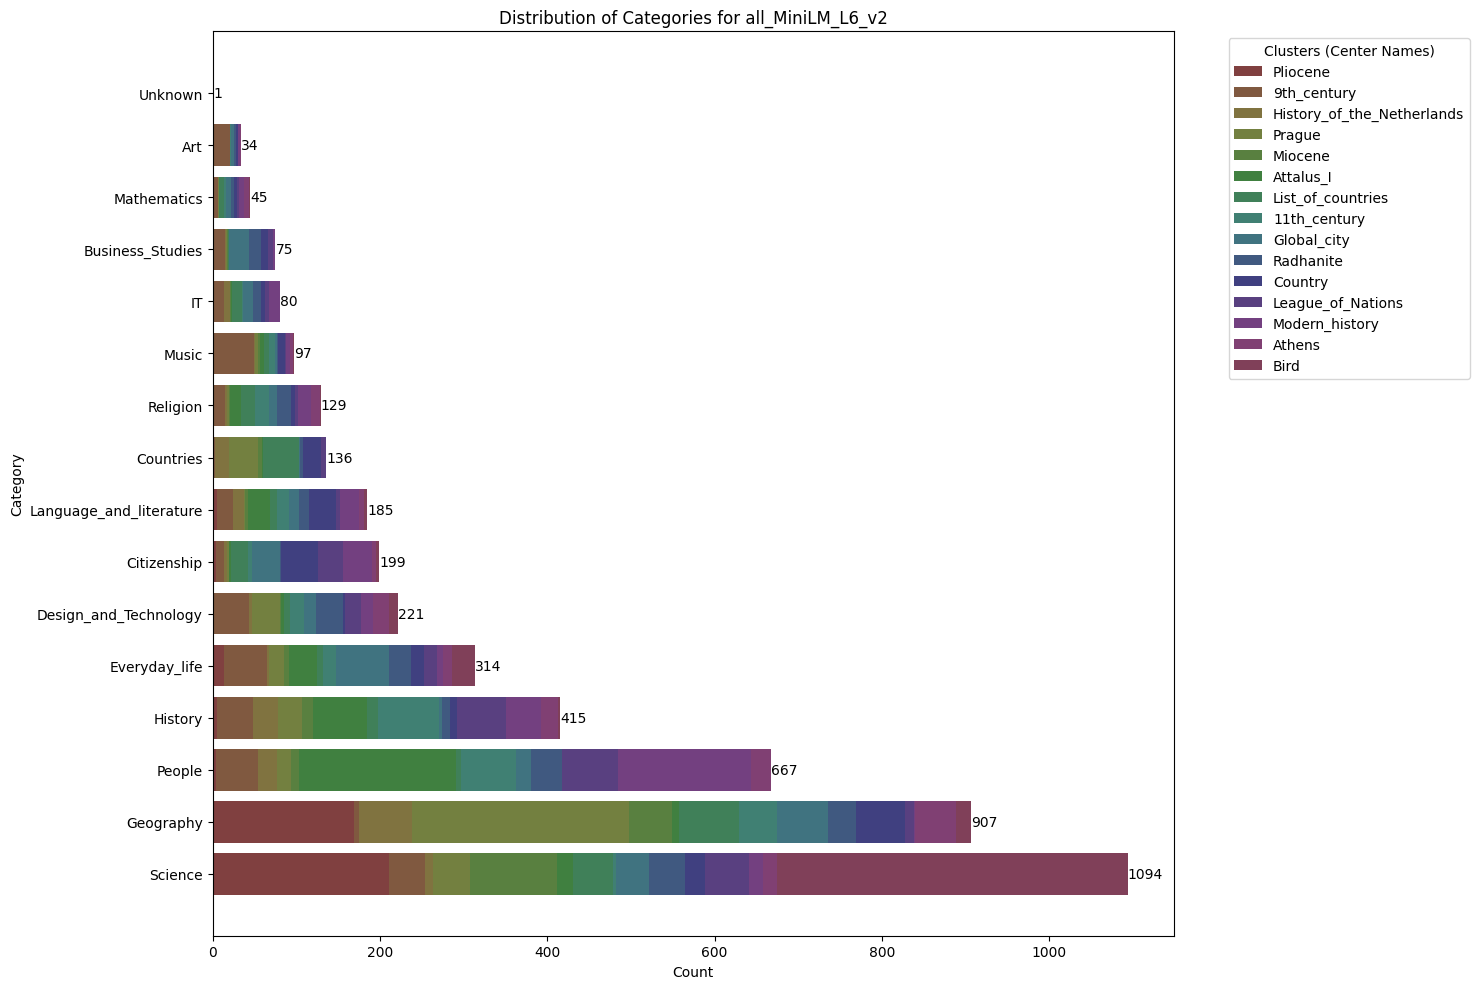

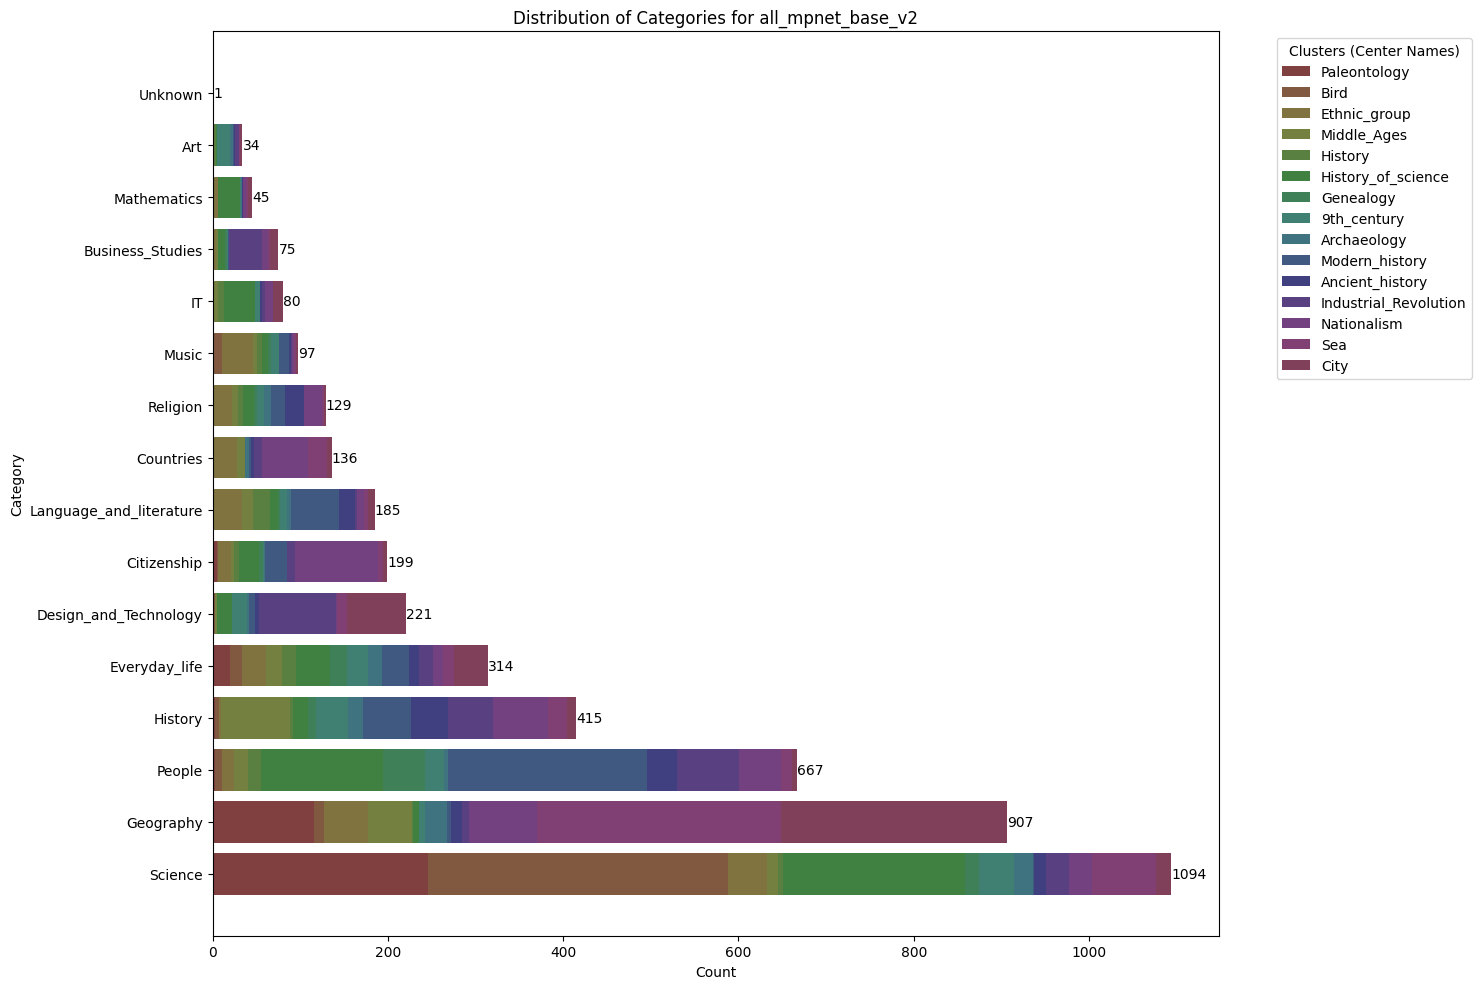

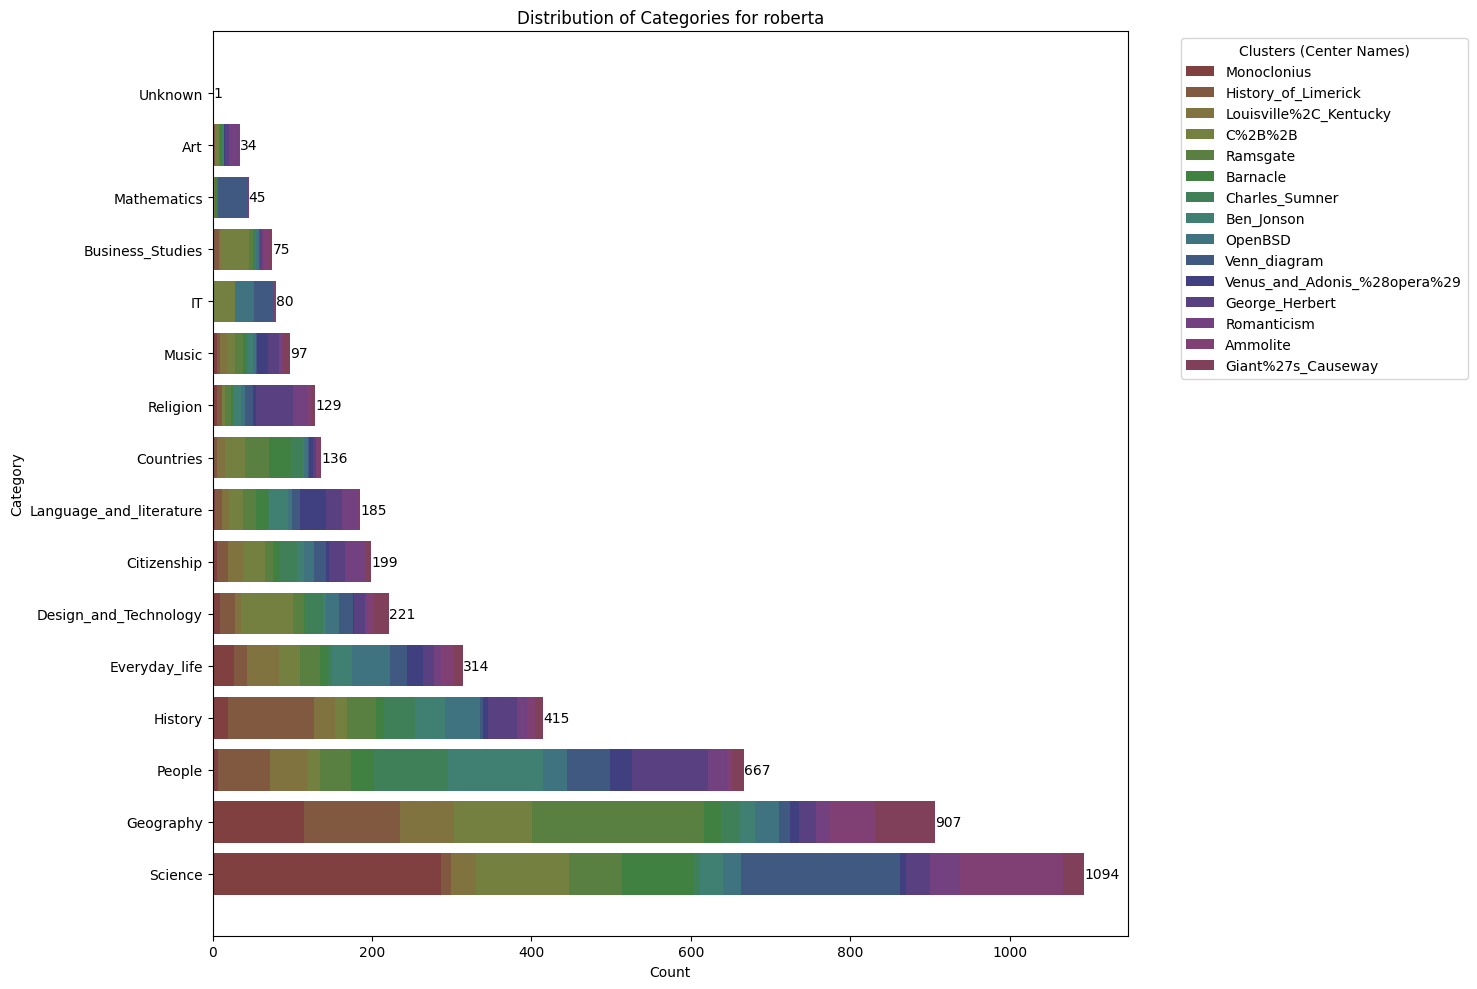

In [23]:
def plot_distribution_stacked(df, column, members_column, title=None, figsize=(15, 10)):
    """
    Plot the distribution of values with each cluster having a unique color,
    sorted by total count and using center_name for cluster labels.
    
    Parameters:
    - df: pandas DataFrame with clustering results
    - column: str, column containing center categories
    - members_column: str, column containing lists of member categories
    - title: str, optional title for the plot
    - figsize: tuple, size of the figure
    """
    # Flatten member categories and count occurrences
    all_categories = df[members_column].explode().value_counts().index
    
    # Generate a color palette with a distinct color for each cluster
    def generate_distinct_colors(n):
        HSV_tuples = [(x*1.0/n, 0.5, 0.5) for x in range(n)]
        return list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
    
    colors = generate_distinct_colors(len(df))
    
    # Prepare the plot
    plt.figure(figsize=figsize)
    
    # Track the bottom of each bar for stacking
    bottom = np.zeros(len(all_categories))
    
    # Plot each cluster with a different color
    for i, (_, row) in enumerate(df.iterrows()):
        center_name = row['center_name']
        member_categories = row[members_column]
        
        # Count category occurrences for this cluster
        category_counts = pd.Series(member_categories).value_counts()
        
        # Create a bar for each category in this cluster
        cluster_bars = []
        for cat in all_categories:
            count = category_counts.get(cat, 0)
            bar = plt.barh(cat, count, left=bottom[all_categories.get_loc(cat)], 
                           color=colors[i], label=center_name)
            cluster_bars.append(bar)
            bottom[all_categories.get_loc(cat)] += count
    
    plt.xlabel('Count')
    plt.ylabel('Category')
    plt.title(title or 'Distribution of Categories Across Clusters')
    
    # Add count labels
    for cat_idx, cat in enumerate(all_categories):
        plt.text(bottom[cat_idx], cat_idx, f'{bottom[cat_idx]:.0f}', 
                 va='center', ha='left')
    
    # Customize legend
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), title='Clusters (Center Names)', 
               bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Usage
for i, model_cluster in enumerate(model_clustering_dfs):
    plot_distribution_stacked(model_cluster, 'center_category', 'members_categories', 
                      title=f'Distribution of Categories for {models[i]}')


## Observations : 
We can see that clusters do not match primary categories at all.